In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.regressor import ResidualsPlot

# Reading data

In [66]:
df = pd.read_csv("../properties_v2.csv", sep=",")

In [67]:
df['neighbourhood'] = df['neighbourhood'].astype(str)

In [68]:
bool_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]

In [69]:
numerical_features = ["area", "rooms", "bathrooms", "garages"]
# numerical_features = ["area", "bathrooms", "garages"]
categorical_features = ["neighbourhood"]
binary_features = bool_cols
target = "price"

In [70]:
df.isnull().sum()[:10]

index        0
id           0
url          0
header       0
address      0
area         0
rooms        0
bathrooms    0
garages      0
price        0
dtype: int64

Condominio muito missing:
Opcao 1a: Remover a coluna
Opcao 1b: Remover as observacoes faltantes
Opcao 2: Imputation (completar os valores faltantes)
Opcao 3: Usar mesmo assim

In [71]:
df = df.dropna(subset = ["area", "rooms", "bathrooms", "garages", "price"])

# Data pipeline

In [72]:
numerical_features

['area', 'rooms', 'bathrooms', 'garages']

In [73]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [74]:
X = df[numerical_features + categorical_features + binary_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [75]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'rooms', 'bathrooms', 'garages'])])

In [76]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [77]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features+binary_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features+binary_features)

# Feature selection

In [78]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
selector.fit(X_train_transformed[numerical_features+binary_features], y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x00000291B03A3D30>)

In [79]:
pd.DataFrame(zip(numerical_features + binary_features, selector.scores_), columns=["feature", "score"]).sort_values("score", ascending=False).head(10)

,feature,score
0,area,0.650093
2,bathrooms,0.352354
3,garages,0.272271
1,rooms,0.229216
17,Churrasqueira,0.028934
68,Piscina,0.024731
91,Salão de festas,0.024058
63,Mobiliado,0.023946
10,Ar-condicionado,0.022741
39,Escritório,0.022511


# Fitting model

# Catboost

In [80]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [81]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [82]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'rooms', 'bathrooms', 'garages'])])

In [83]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [84]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features)

In [85]:
model = CatBoostRegressor(cat_features=["neighbourhood"])
model.fit(X_train_transformed, y_train, eval_set=(X_test_transformed, y_test), verbose=False)

In [86]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [87]:
mape_catboost = mean_absolute_percentage_error(y_test, y_pred)

In [88]:
r2_catboost = r2_score(y_test, y_pred)

In [89]:
mape_catboost_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [90]:
r2_catboost_train = r2_score(y_train, y_pred_train)

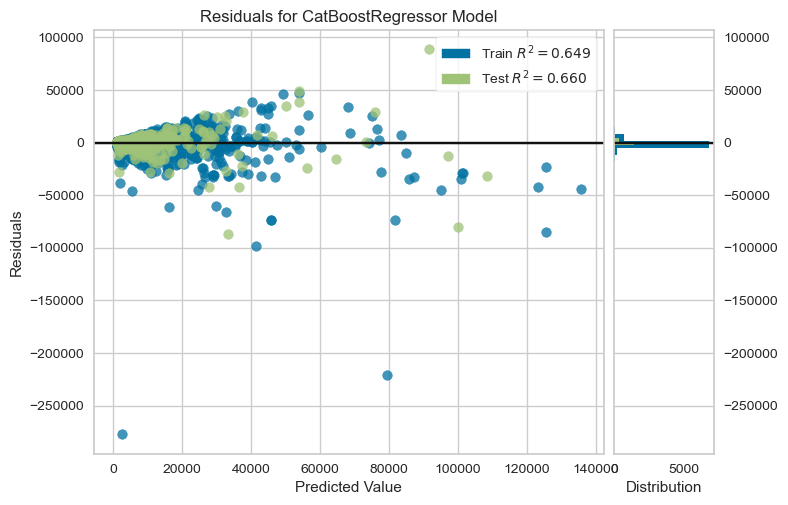

<AxesSubplot:title={'center':'Residuals for CatBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [91]:
wrapped_model = wrap(model)
visualizer = ResidualsPlot(wrapped_model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

In [92]:
import pickle
pickle.dump(model, open('C:/Users/erycm/Documents/ciencia dos dados/awari/calculadora_aluguel/deploy/model.pkl', 'wb'))
pickle.dump(data_pipeline, open('C:/Users/erycm/Documents/ciencia dos dados/awari/calculadora_aluguel/deploy/data_pipeline.pkl', 'wb'))